In [30]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import adapters
from adapters import AutoAdapterModel
from sentence_transformers import SentenceTransformer
import gc

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [73]:
%load_ext autoreload
%autoreload 2

from metrics import knn_accuracy
from embeddings import generate_embeddings
from plotting import plot_tsne_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [12]:
variables_path = Path("../results/variables/iclr24v2")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [13]:
plt.style.use("matplotlib_style.txt")

In [14]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-03-19 03:08:08CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

sklearn        : 1.3.2
openTSNE       : 1.0.0
black          : 23.11.0
scipy          : 1.11.4
numpy          : 1.26.2
adapters       : 0.1.0
matplotlib     : 3.8.2
memory_profiler: 0.61.0
distro         : 1.8.0
pandas         : 2.1.3
jupyter_black  : 0.3.4
torch          : 2.1.1

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

In [18]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr24v2.parquet",
    engine="pyarrow",
)

CPU times: user 184 ms, sys: 97.6 ms, total: 282 ms
Wall time: 220 ms


In [19]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [20]:
iclr2024

year          id                                              title  \
0      2017   B1-Hhnslg        Prototypical Networks for Few-shot Learning   
1      2017   B1-q5Pqxl  Machine Comprehension Using Match-LSTM and Ans...   
2      2017   B16Jem9xe             Learning in Implicit Generative Models   
3      2017   B16dGcqlx                    Third Person Imitation Learning   
4      2017   B184E5qee  Improving Neural Language Models with a Contin...   
...     ...         ...                                                ...   
24343  2024  zxPDdw8koz  CLIP meets Model Zoo Experts: Pseudo-Supervisi...   
24344  2024  zyBJodMrn5  On the generalization capacity of neural netwo...   
24345  2024  zz61V8bIab  Stochastic Adversarial Networks for Multi-Doma...   
24346  2024  zzqn5G9fjn  Breaking Physical and Linguistic Borders: Mult...   
24347  2024  zzv4Bf50RW  Learning SO(3)-Invariant Correspondence via Po...   

                                                abstract  \
0      A recent approach to few-shot classification c...   
1      Machine comprehension of text is an important ...   
2      Generative adversarial networks (GANs) provide...   
3      Reinforcement learning (RL) makes it possible ...   
4      We propose an extension to neural network lang...   
...                                                  ...   
24343  Contrastive language image pretraining (CLIP) ...   
24344  The advent of the Transformer has led to the d...   
24345  Adversarial training has played a pivotal role...   
24346  Pretrained large language models (LLMs) have e...   
24347  Establishing accurate dense 3D correspondences...   

                                                 authors  \
0               Jake Snell, Kevin Swersky, Richard Zemel   
1                              Shuohang Wang, Jing Jiang   
2                Shakir Mohamed, Balaji Lakshminarayanan   
3         Bradly C Stadie, Pieter Abbeel, Ilya Sutskever   
4          Edouard Grave, Armand Joulin, Nicolas Usunier   
...                                                  ...   
24343                                                      
24344  Takuya Ito, Soham Dan, Mattia Rigotti, James K...   
24345                                                      
24346  Wanru Zhao, Royson Lee, Yihong Chen, Xinchi Qi...   
24347                                                      

                       decision           scores  \
0                        Reject        [6, 4, 5]   
1               Accept (Poster)        [6, 6, 7]   
2      Invite to Workshop Track        [8, 7, 6]   
3               Accept (Poster)        [6, 5, 6]   
4               Accept (Poster)        [7, 9, 5]   
...                         ...              ...   
24343                 Withdrawn     [8, 3, 3, 3]   
24344           Accept (poster)        [8, 3, 6]   
24345                 Withdrawn        [5, 1, 5]   
24346           Accept (poster)     [5, 3, 1, 8]   
24347                 Withdrawn  [5, 5, 3, 5, 6]   

                                                keywords  \
0                     [deep learning, transfer learning]   
1           [natural language processing, deep learning]   
2                                [unsupervised learning]   
3                                                     []   
4                          [natural language processing]   
...                                                  ...   
24343  [contrastive learning, clip, distillation, den...   
24344  [compositional generalization, compositionalit...   
24345  [multi-domain text classification, adversarial...   
24346  [multilingual federated learning, natural lang...   
24347  [point cloud understanding, 3d dense correspon...   

                       labels  
0           transfer learning  
1             language models  
2                   unlabeled  
3                   unlabeled  
4             language models  
...                       ...  
24343  vision-language models  
24344     out-of-distribut

In [29]:
labels_iclr = iclr2024.labels.to_numpy()

In [21]:
colors_iclr = np.load(variables_path / "colors_iclr.npy")

pickle_in = open(variables_path / "dict_label_to_color.pkl", "rb")
dict_label_to_color = pickle.load(pickle_in)

In [56]:
iclr2024.columns

Index(['index', 'year', 'id', 'title', 'abstract', 'authors', 'decision',
       'scores', 'keywords', 'gender-first', 'gender-last', 't-SNE x',
       't-SNE y'],
      dtype='object')

In [62]:
df_copy = iclr2024[
    [
        # "index",
        "year",
        "id",
        "title",
        "abstract",
        "authors",
        "decision",
        "scores",
        "keywords",
    ]
].copy(deep=True)

In [63]:
df_copy.head()

year         id                                              title  \
0  2017  S1VaB4cex  FractalNet: Ultra-Deep Neural Networks without...   
1  2017  H1W1UN9gg                       Deep Information Propagation   
2  2017  r1GKzP5xx                Recurrent Normalization Propagation   
3  2017  S1J0E-71l    Surprisal-Driven Feedback in Recurrent Networks   
4  2017  SJGCiw5gl  Pruning Convolutional Neural Networks for Reso...   

                                            abstract  \
0  We introduce a design strategy for neural netw...   
1  We study the behavior of untrained neural netw...   
2  We propose a LSTM parametrization  that preser...   
3  Recurrent neural nets are widely used for pred...   
4  We propose a new formulation for pruning convo...   

                                             authors  \
0  Gustav Larsson, Michael Maire, Gregory Shakhna...   
1  Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2      César Laurent, Nicolas Ballas, Pascal Vincent   
3                    K, a, m, i, l,  , R, o, c, k, i   
4  Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   

                   decision        scores  \
0           Accept (Poster)  [5, 7, 6, 6]   
1           Accept (Poster)     [8, 9, 8]   
2  Invite to Workshop Track     [4, 6, 6]   
3                    Reject     [3, 4, 3]   
4           Accept (Poster)     [6, 7, 9]   

                                            keywords  
0                                                 []  
1                            [theory, deep learning]  
2                      [deep learning, optimization]  
3  [unsupervised learning, applications, deep lea...  
4                 [deep learning, transfer learning]

In [64]:
df_copy["labels"] = labels_iclr

In [65]:
df_copy.head()

year         id                                              title  \
0  2017  S1VaB4cex  FractalNet: Ultra-Deep Neural Networks without...   
1  2017  H1W1UN9gg                       Deep Information Propagation   
2  2017  r1GKzP5xx                Recurrent Normalization Propagation   
3  2017  S1J0E-71l    Surprisal-Driven Feedback in Recurrent Networks   
4  2017  SJGCiw5gl  Pruning Convolutional Neural Networks for Reso...   

                                            abstract  \
0  We introduce a design strategy for neural netw...   
1  We study the behavior of untrained neural netw...   
2  We propose a LSTM parametrization  that preser...   
3  Recurrent neural nets are widely used for pred...   
4  We propose a new formulation for pruning convo...   

                                             authors  \
0  Gustav Larsson, Michael Maire, Gregory Shakhna...   
1  Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2      César Laurent, Nicolas Ballas, Pascal Vincent   
3                    K, a, m, i, l,  , R, o, c, k, i   
4  Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   

                   decision        scores  \
0           Accept (Poster)  [5, 7, 6, 6]   
1           Accept (Poster)     [8, 9, 8]   
2  Invite to Workshop Track     [4, 6, 6]   
3                    Reject     [3, 4, 3]   
4           Accept (Poster)     [6, 7, 9]   

                                            keywords             labels  
0                                                 []          unlabeled  
1                            [theory, deep learning]          unlabeled  
2                      [deep learning, optimization]       optimization  
3  [unsupervised learning, applications, deep lea...          unlabeled  
4                 [deep learning, transfer learning]  transfer learning

In [66]:
# %%time
df_copy.to_parquet(
    "/gpfs01/berens/user/rgonzalesmarquez/phd/iclr-dataset/data/iclr24v1.parquet.gzip",  # ICLR24v1
    index=False,
    engine="pyarrow",
    compression="gzip",
)

In [69]:
# %%time
df_copy_test = pd.read_parquet(
    "/gpfs01/berens/user/rgonzalesmarquez/phd/iclr-dataset/data/iclr24v1.parquet.gzip",  # ICLR24v1
    engine="pyarrow",
)

In [70]:
df_copy_test

year          id                                              title  \
0      2017   S1VaB4cex  FractalNet: Ultra-Deep Neural Networks without...   
1      2017   H1W1UN9gg                       Deep Information Propagation   
2      2017   r1GKzP5xx                Recurrent Normalization Propagation   
3      2017   S1J0E-71l    Surprisal-Driven Feedback in Recurrent Networks   
4      2017   SJGCiw5gl  Pruning Convolutional Neural Networks for Reso...   
...     ...         ...                                                ...   
24342  2024  1bbPQShCT2            I-PHYRE: Interactive Physical Reasoning   
24343  2024  Ny150AblPu  EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...   
24344  2024  ZGBOfAQrMl  Video Super-Resolution Transformer with Masked...   
24345  2024  J2kRjUAOLh  Contrastive Predict-and-Search for Mixed Integ...   
24346  2024  U0P622bfUN  Federated Generative Learning with Foundation ...   

                                                abstract  \
0      We introduce a design strategy for neural netw...   
1      We study the behavior of untrained neural netw...   
2      We propose a LSTM parametrization  that preser...   
3      Recurrent neural nets are widely used for pred...   
4      We propose a new formulation for pruning convo...   
...                                                  ...   
24342  Current evaluation protocols predominantly ass...   
24343  In the battle against widespread online misinf...   
24344  Recently, Vision Transformer has achieved grea...   
24345  Mixed integer linear programs  (MILP) are flex...   
24346  Existing federated learning solutions focus on...   

                                                 authors  \
0      Gustav Larsson, Michael Maire, Gregory Shakhna...   
1      Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2          César Laurent, Nicolas Ballas, Pascal Vincent   
3                        K, a, m, i, l,  , R, o, c, k, i   
4      Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   
...                                                  ...   
24342                                                      
24343                                                      
24344                                                      
24345                                                      
24346                                                      

                       decision        scores  \
0               Accept (Poster)  [5, 7, 6, 6]   
1               Accept (Poster)     [8, 9, 8]   
2      Invite to Workshop Track     [4, 6, 6]   
3                        Reject     [3, 4, 3]   
4               Accept (Poster)     [6, 7, 9]   
...                         ...           ...   
24342                                      []   
24343                                      []   
24344                                      []   
24345                                      []   
24346                                      []   

                                                keywords              labels  
0                                                     []           unlabeled  
1                                [theory, deep learning]           unlabeled  
2                          [deep learning, optimization]        optimization  
3      [unsupervised learning, applications, deep lea...           unlabeled  
4                     [deep learning, transfer learning]   transfer learning  
...                                                  ...                 ...  
24342            [intuitive physics, physical reasoning]           unlabeled  
24343            [mis-contextualization, media forensic]           unlabeled  
24344  [video super-resolution, adaptive, memory and ...           unlabeled  
24345     [mixed integer programs; contrastive learning]           unlabeled  
24346                 [federated learning, non-iid data]  federated learning  

[24347 rows x 9 columns]

In [75]:
for elem in df_copy_test.columns:
    print("- ", elem.capitalize())

-  Year
-  Id
-  Title
-  Abstract
-  Authors
-  Decision
-  Scores
-  Keywords
-  Labels


In [80]:
df_copy_test.iloc[42].to_dict()

{'year': 2017,
 'id': 'r1nTpv9eg',
 'title': 'Learning to Perform Physics Experiments via Deep Reinforcement Learning',
 'abstract': 'When encountering novel objects, humans are able to infer a wide range of physical properties such as mass, friction and deformability by interacting with them in a goal driven way. This process of active interaction is in the same spirit as a scientist performing experiments to discover hidden facts. Recent advances in artificial intelligence have yielded machines that can achieve superhuman performance in Go, Atari, natural language processing, and complex control problems; however, it is not clear that these systems can rival the scientific intuition of even a young child. In this work we introduce a basic set of tasks that require agents to estimate properties such as mass and cohesion of objects in an interactive simulated environment where they can manipulate the objects and observe the consequences. We found that deep reinforcement learning method

In [ ]:
Model | $k$NN accuracy
--- | ---
TF-IDF | 60.0%
SVD | 60.6%
SVD, $L_2$ norm. | 62.4%
--- | ---
DeCLUTR-sci | 53.5% 
SciNCL | 57.0%  
SPECTER2 | 58.2%  
Cohere Embed | 62.9%
SBERT | **63.3%**

In [81]:
%%time
iclr24v1 = pd.read_parquet(
    data_path / "iclr24v1.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 352 ms, sys: 119 ms, total: 471 ms
Wall time: 477 ms


In [82]:
iclr24v1

year          id                                              title  \
0      2017   S1VaB4cex  FractalNet: Ultra-Deep Neural Networks without...   
1      2017   H1W1UN9gg                       Deep Information Propagation   
2      2017   r1GKzP5xx                Recurrent Normalization Propagation   
3      2017   S1J0E-71l    Surprisal-Driven Feedback in Recurrent Networks   
4      2017   SJGCiw5gl  Pruning Convolutional Neural Networks for Reso...   
...     ...         ...                                                ...   
24342  2024  1bbPQShCT2            I-PHYRE: Interactive Physical Reasoning   
24343  2024  Ny150AblPu  EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...   
24344  2024  ZGBOfAQrMl  Video Super-Resolution Transformer with Masked...   
24345  2024  J2kRjUAOLh  Contrastive Predict-and-Search for Mixed Integ...   
24346  2024  U0P622bfUN  Federated Generative Learning with Foundation ...   

                                                abstract  \
0      We introduce a design strategy for neural netw...   
1      We study the behavior of untrained neural netw...   
2      We propose a LSTM parametrization  that preser...   
3      Recurrent neural nets are widely used for pred...   
4      We propose a new formulation for pruning convo...   
...                                                  ...   
24342  Current evaluation protocols predominantly ass...   
24343  In the battle against widespread online misinf...   
24344  Recently, Vision Transformer has achieved grea...   
24345  Mixed integer linear programs  (MILP) are flex...   
24346  Existing federated learning solutions focus on...   

                                                 authors  \
0      Gustav Larsson, Michael Maire, Gregory Shakhna...   
1      Samuel S. Schoenholz, Justin Gilmer, Surya Gan...   
2          César Laurent, Nicolas Ballas, Pascal Vincent   
3                        K, a, m, i, l,  , R, o, c, k, i   
4      Pavlo Molchanov, Stephen Tyree, Tero Karras, T...   
...                                                  ...   
24342                                                      
24343                                                      
24344                                                      
24345                                                      
24346                                                      

                       decision        scores  \
0               Accept (Poster)  [5, 7, 6, 6]   
1               Accept (Poster)     [8, 9, 8]   
2      Invite to Workshop Track     [4, 6, 6]   
3                        Reject     [3, 4, 3]   
4               Accept (Poster)     [6, 7, 9]   
...                         ...           ...   
24342                                      []   
24343                                      []   
24344                                      []   
24345                                      []   
24346                                      []   

                                                keywords              labels  
0                                                     []           unlabeled  
1                                [theory, deep learning]           unlabeled  
2                          [deep learning, optimization]        optimization  
3      [unsupervised learning, applications, deep lea...           unlabeled  
4                     [deep learning, transfer learning]   transfer learning  
...                                                  ...                 ...  
24342            [intuitive physics, physical reasoning]           unlabeled  
24343            [mis-contextualization, media forensic]           unlabeled  
24344  [video super-resolution, adaptive, memory and ...           unlabeled  
24345     [mixed integer programs; contrastive learning]           unlabeled  
24346                 [federated learning, non-iid data]  federated learning  

[24347 rows x 9 columns]

###  Check PubMed status

In [95]:
print(
    np.load(
        "/gpfs01/berens/data/data/pubmed_processed/embeddings/2024_baseline/last_i_batch.npy"
    )
)

69000


In [2]:
(69000) * 256 / 23389083

0.755224135978311

# Obtain representation

## BERT-based models

### General pipeline

In [25]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    # "SPECTER2",
    # "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    # "allenai/specter2_base",
    # "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SBERT']


In [26]:
%%time
for i, model_name in enumerate(model_names):
    # set up model
    print("Model: ", model_name)

    random_state = random.seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256
    )

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "embedding_abstracts_only_cls",
        embedding_cls,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_sep",
        embedding_sep,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_av",
        embedding_av,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SimCSE
Running on device: cuda
princeton-nlp/unsup-simcse-bert-base-uncased


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  DeCLUTR-sci
Running on device: cuda
johngiorgi/declutr-sci-base


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SciNCL
Running on device: cuda
malteos/scincl


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 7min 37s, sys: 12min 41s, total: 20min 19s
Wall time: 13min 35s


### SPECTER2

In [27]:
%%time
# SPECTER 2
model_name = "SPECTER2"
model_path = "allenai/specter2_base"

# set up model
print('Model: ', model_name)

random_state = random.seed(42)
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoAdapterModel.from_pretrained(model_path)
print(model_path)
# add adapter proximity
#load the adapter(s) as per the required task, provide an identifier for the adapter in load_as argument and activate it
model.load_adapter("allenai/specter2", source="hf", load_as="specter2", set_active=True)

model = model.to(device)

# get embeddings
embedding_cls, embedding_sep, embedding_av = generate_embeddings(iclr2024.abstract.to_list(), tokenizer, model, device, batch_size=256)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(parents=True,exist_ok=True)

np.save(variables_path/saving_path/"embedding_abstracts_only_cls", embedding_cls)
np.save(variables_path/saving_path/"embedding_abstracts_only_sep", embedding_sep)
np.save(variables_path/saving_path/"embedding_abstracts_only_av", embedding_av)

model = None
gc.collect()
torch.cuda.empty_cache()

print('----------------------------')



Model:  SPECTER2
Running on device: cuda
allenai/specter2_base


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1min 53s, sys: 3min 10s, total: 5min 4s
Wall time: 3min 35s


### ST5

When sentence_transformers is used in output_value="token_embeddings" mode, a "end of senctence" ("eos", similar to CLS) token is appended at the end of the sentence before the padding. The output of model.encode is a list though, and it has no padding tokens in every element, so the EOS token is just the last one.

I dont really know what the output is in mode output_value="sentence_embeddings", but I asume mean pooling of all tokens.

In [17]:
from sentence_transformers import SentenceTransformer

import sentence_transformers

sentence_transformers.__version__

'2.5.1'

In [31]:
?SentenceTransformer

Init signature:
SentenceTransformer(
    model_name_or_path: Optional[str] = None,
    modules: Optional[Iterable[torch.nn.modules.module.Module]] = None,
    device: Optional[str] = None,
    prompts: Optional[Dict[str, str]] = None,
    default_prompt_name: Optional[str] = None,
    cache_folder: Optional[str] = None,
    trust_remote_code: bool = False,
    revision: Optional[str] = None,
    token: Union[bool, str, NoneType] = None,
    use_auth_token: Union[bool, str, NoneType] = None,
)
Docstring:     
Loads or creates a SentenceTransformer model that can be used to map sentences / text to embeddings.

:param model_name_or_path: If it is a filepath on disc, it loads the model from that path. If it is not a path,
    it first tries to download a pre-trained SentenceTransformer model. If that fails, tries to construct a model
    from the Hugging Face Hub with that name.
:param modules: A list of torch Modules that should be called sequentially, can be used to create custom
    Sen

In [39]:
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer(
    "sentence-transformers/sentence-t5-base"
)  # , device="cuda")
embeddings = model.encode(
    sentences, output_value="token_embeddings", convert_to_tensor=True
)
print(embeddings)
print(type(embeddings))
print(embeddings[0].shape)
print(embeddings[1].shape)

[tensor([[ 0.1087,  0.0407, -0.1398,  ...,  0.1000, -0.0860, -0.0583],
        [-0.0079,  0.0146, -0.0060,  ...,  0.0283,  0.0054, -0.0067],
        [-0.0089, -0.0094, -0.0028,  ...,  0.0096,  0.0080, -0.0116],
        [ 0.1018,  0.0015, -0.1868,  ...,  0.0138,  0.3689,  0.0749],
        [-0.1467,  0.1837, -0.1458,  ..., -0.2221,  0.5728, -0.1461],
        [ 0.0171,  0.1270, -0.0777,  ..., -0.0599,  0.1117, -0.1966]],
       device='cuda:0'), tensor([[ 0.0587,  0.0733, -0.0882,  ...,  0.0740, -0.1640,  0.0976],
        [ 0.0183,  0.1378, -0.1671,  ...,  0.0997,  0.5533, -0.4041],
        [-0.0381, -0.0192,  0.0094,  ...,  0.0156,  0.0545, -0.0220],
        [-0.2468,  0.0537, -0.3107,  ...,  0.2940,  0.3538, -0.0822],
        [ 0.0220,  0.1275, -0.0723,  ..., -0.0507,  0.1181, -0.1882]],
       device='cuda:0')]
<class 'list'>
torch.Size([6, 768])
torch.Size([5, 768])


In [33]:
model.tokenize(sentences)

{'input_ids': tensor([[  100,    19,    46,   677,  7142,     1],
         [ 1698,  7142,    19, 12069,     1,     0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 0]])}

In [35]:
model.tokenizer  # .decode(sentences)

T5TokenizerFast(name_or_path='sentence-transformers/sentence-t5-base', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42

In [57]:
model.tokenizer.decode(
    token_ids=model.tokenize(sentences)["input_ids"][0].numpy()
)

'This is an example sentence</s>'

In [21]:
?model.encode(batch_size = 256, show_progress_bar=True, device="cuda",normalize_embeddings=False

Signature:
model.encode(
    sentences: Union[str, List[str]],
    prompt_name: Optional[str] = None,
    prompt: Optional[str] = None,
    batch_size: int = 32,
    show_progress_bar: bool = None,
    output_value: str = 'sentence_embedding',
    convert_to_numpy: bool = True,
    convert_to_tensor: bool = False,
    device: str = None,
    normalize_embeddings: bool = False,
) -> Union[List[torch.Tensor], numpy.ndarray, torch.Tensor]
Docstring:
Computes sentence embeddings.

:param sentences: the sentences to embed.
:param prompt_name: The name of the prompt to use for encoding. Must be a key in the `prompts` dictionary,
    which is either set in the constructor or loaded from the model configuration. For example if
    `prompt_name` is ``"query"`` and the `prompts` is ``{"query": "query: ", ...}``, then the sentence "What
    is the capital of France?" will be encoded as "query: What is the capital of France?" because the sentence
    is appended to the prompt. If `prompt` is also 

In [24]:
# preprocess the input
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

inputs = tokenizer(
    sentences,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
)  # .to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [47]:
print(inputs["input_ids"].shape)
inputs["input_ids"].numpy()

torch.Size([2, 7])


array([[ 101, 2023, 2003, 2019, 2742, 6251,  102],
       [ 101, 2169, 6251, 2003, 4991,  102,    0]])

In [49]:
# ?tokenizer.decode
tokenizer.decode(token_ids=inputs["input_ids"].numpy()[0])

'[CLS] this is an example sentence [SEP]'

In [32]:
%%time
# ST5
model_name = "ST5"
model_path = "sentence-transformers/sentence-t5-base"

# set up model
print("Model: ", model_name)

random_state = random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

print(model_path)
model = SentenceTransformer(model_path, device="cuda")

# get embeddings
embedding_av = model.encode(
    iclr2024.abstract.to_list(),
    batch_size=256,
    show_progress_bar=True,
    output_value="sentence_embedding",
    device="cuda",
    normalize_embeddings=False,  # the output is still normalized for some reason
)

# save embeddings
saving_path = Path("embeddings_" + model_name.lower())
(variables_path / saving_path).mkdir(parents=True, exist_ok=True)

np.save(
    variables_path / saving_path / "embedding_abstracts_only_av", embedding_av
)

model = None
gc.collect()
torch.cuda.empty_cache()

print("----------------------------")

Model:  ST5
Running on device: cuda
sentence-transformers/sentence-t5-base


Batches:   0%|          | 0/96 [00:00<?, ?it/s]

----------------------------
CPU times: user 2min 43s, sys: 1min 19s, total: 4min 3s
Wall time: 1min 26s


In [14]:
titles_abstracts_together = [
    iclr2024.title[i] + " " + iclr2024.abstract[i]
    for i in range(len(iclr2024))
]

In [15]:
print(len(titles_abstracts_together))

24347


In [16]:
model_names = [
    "SBERT",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # # "SPECTER2",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    # # "allenai/specter2_base",
]
print(model_names)

['SBERT']


In [17]:
%%time
for i, model_name in enumerate(model_names):
    # set up model
    print('Model: ', model_name)
    
    random_state = random.seed(42)
    device = (
        "cuda" if torch.cuda.is_available() else "cpu"
    )  
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(titles_abstracts_together, tokenizer, model, device, batch_size=128)

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower()) / Path("updated_dataset")
    (variables_path / saving_path).mkdir(parents=True,exist_ok=True)

    np.save(variables_path/saving_path/"embedding_cls", embedding_cls)
    np.save(variables_path/saving_path/"embedding_sep", embedding_sep)
    np.save(variables_path/saving_path/"embedding_av", embedding_av)
    
    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print('----------------------------')



Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/191 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 2min 44s, sys: 8min 32s, total: 11min 16s
Wall time: 9min 58s


## TF-IDF

In [33]:
%%time
%%memit

# TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(iclr2024.abstract.to_list())

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3652.59 MiB, increment: 0.03 MiB
CPU times: user 2.22 s, sys: 206 ms, total: 2.43 s
Wall time: 2.62 s


In [34]:
print(tfidf_features.shape)

(24348, 44434)


In [35]:
# save results
sp.sparse.save_npz(variables_path / "tfidf_features", tfidf_features)

## Truncated SVD

In [36]:
%%time
%%memit

# TruncatedSVD
svd = TruncatedSVD(n_components=768, random_state=42, algorithm="arpack")
svd_data = svd.fit_transform(tfidf_features)

# save results
np.save(variables_path / "svd_data", svd_data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3652.61 MiB, increment: 0.00 MiB
CPU times: user 47min 7s, sys: 38min 25s, total: 1h 25min 32s
Wall time: 2min 13s


In [20]:
%%time
%%memit
np.random.seed(42)
P = 2 * np.random.randint(0, 2, size=(tfidf_features.shape[1], 768)) - 1
random_projection = tfidf_features @ P
print(random_projection.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(24347, 768)
peak memory: 3220.09 MiB, increment: 140.10 MiB
CPU times: user 1.34 s, sys: 274 ms, total: 1.61 s
Wall time: 1.69 s


In [21]:
np.save(variables_path / "updated_dataset" / "random_projection", random_projection)

In [22]:
random_projection

array([[-0.0816497 , -1.9272318 , -0.36346166, ..., -0.12204631,
        -0.88916892, -0.13117145],
       [ 1.999188  , -2.2292684 ,  0.01407417, ...,  2.80495073,
        -1.42359785,  0.15102736],
       [ 0.10235032, -0.16213538,  0.91836754, ..., -0.89349167,
         0.18893009, -0.45007368],
       ...,
       [ 0.74128474,  0.58348352, -1.58598404, ...,  0.13042953,
        -0.79660597, -2.32230746],
       [ 0.48121637, -0.36561139,  2.4199486 , ..., -0.29046269,
        -0.65948993,  0.50788325],
       [-0.02918886, -0.06590328,  0.0814197 , ..., -0.14795635,
         0.71064846, -1.44202104]])

# kNN accuracy

## BERT-based models

In [37]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


### Euclidean

In [83]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            embedding_av[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="euclidean",
        )
    else:
        knn_acc = knn_accuracy(
            [
                embedding_av[labels_iclr != "unlabeled"],
                embedding_cls[labels_iclr != "unlabeled"],
                embedding_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="euclidean",
        )

    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [44.9 47.1 44.4]
DeCLUTR-sci: [53.4 40.1 32.2]
SciNCL: [57.2 59.7 59. ]
SPECTER2: [57.3 58.7 61.5]
ST5: 57.0
SBERT: [62.9 63.1 62.3]
peak memory: 4448.38 MiB, increment: 3.36 MiB
CPU times: user 41 s, sys: 5.81 s, total: 46.8 s
Wall time: 4.03 s


In [84]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [44.9 47.1 44.4]
DeCLUTR-sci: [53.4 40.1 32.2]
SciNCL: [57.2 59.7 59. ]
SPECTER2: [57.3 58.7 61.5]
ST5: 57.0
SBERT: [62.9 63.1 62.3]
peak memory: 4445.30 MiB, increment: 0.00 MiB
CPU times: user 277 ms, sys: 115 ms, total: 392 ms
Wall time: 525 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Cosine

In [85]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())
    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            embedding_av[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )
    else:
        knn_acc = knn_accuracy(
            [
                embedding_av[labels_iclr != "unlabeled"],
                embedding_cls[labels_iclr != "unlabeled"],
                embedding_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )

    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # save embeddings
    saving_name = Path("knn_accuracy_cosine_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [46.7 47.3 44.5]
DeCLUTR-sci: [53.8 40.  32.1]
SciNCL: [56.3 59.4 59.4]
SPECTER2: [57.7 58.9 61.4]
ST5: 57.0
SBERT: [62.  62.6 62.5]
peak memory: 4529.93 MiB, increment: 87.58 MiB
CPU times: user 2min 41s, sys: 5min 38s, total: 8min 20s
Wall time: 13.1 s


In [40]:
model_names = [
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]
print(model_names)

['SimCSE', 'DeCLUTR', 'DeCLUTR-sci', 'SPECTER2']


In [41]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    embedding_cls = np.load(
        variables_path / saving_path / "embedding_abstracts_only_cls.npy"
    )
    embedding_sep = np.load(
        variables_path / saving_path / "embedding_abstracts_only_sep.npy"
    )
    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # print(type(embedding_av))

    # knn acc
    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )
    print(f"{model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower())
    np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]


FileNotFoundError: [Errno 2] No such file or directory: '../results/variables/iclr24v2/embeddings_simcse/updated_dataset/embedding_abstracts_only_cls.npy'

In [42]:
model_names = [
    "BERT",
    "MPNet",
    "SBERT",
    "SciBERT",
    "SPECTER",
    "SciNCL",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]

In [43]:
# new order
model_names = [
    "MPNet",
    "BERT",
    "SciBERT",
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER",
    "SPECTER2",
    "SBERT",
]

In [9]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / "updated_dataset" / saving_name)
    print(f"{model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy     [AVG]    [CLS]   [SEP]
MPNet: [37.4 31.8 36.3]
BERT: [40.6 28.2 33.1]
SciBERT: [44.5 21.5 28.5]
SimCSE: [45.7 43.5 46.4]
DeCLUTR: [50.3 45.  34.8]
DeCLUTR-sci: [53.5 38.8 29.2]
SciNCL: [57.  56.8 57.8]
SPECTER: [56.8 54.1 58.5]
SPECTER2: [58.2 57.2 59.7]
SBERT: [63.3 56.8 59.8]
peak memory: 617.73 MiB, increment: 0.00 MiB
CPU times: user 168 ms, sys: 146 ms, total: 314 ms
Wall time: 329 ms


kNN accuracy   &  [AVG]   & [CLS]  & [SEP]\\
MPNet & 37.\%4 &  31.8\% &  36.3\% \\
BERT & 40.\%6 &  28.2\% &  33.1\% \\
SciBERT & 44.\%5 &  21.5\% &  28.5\% \\
SimCSE & 45.\%7 &  43.5\% &  46.4\% \\
DeCLUTR & \%50.3 &  4\%5.  &  34.8\% \\
DeCLUTR-sci & 53.\%5  & 38.8\% & 9.2\%\\
SciNCL & 57.0\%  &  56.8\% &  57.8\% \\
SPECTER & 56.\%8 &  54.1\% &  58.5\% \\
SPECTER2 & 58.\%2 &  57.2\% &  59.7\% \\
SBERT & 63.\%3 &  56.8\% &  59.8\% \\

In [58]:
model_names = [
    "ST5",
]


model_paths = [
    "sentence-transformers/sentence-t5-base",
]
print(model_names)

['ST5']


In [62]:
%%time
%%memit
print("kNN accuracy     [AVG]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    # embedding_cls = np.load(
    #     variables_path / saving_path / "embedding_abstracts_only_cls.npy"
    # )
    # embedding_sep = np.load(
    #     variables_path / saving_path / "embedding_abstracts_only_sep.npy"
    # )
    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # print(type(embedding_av))

    # knn acc
    knn_acc = knn_accuracy(
        embedding_av[labels_iclr != "unlabeled"],
        labels_iclr[labels_iclr != "unlabeled"],
    )
    print(f"{model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower())
    np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]
ST5: 58.30769230769231
peak memory: 2753.89 MiB, increment: 100.25 MiB
CPU times: user 4.52 s, sys: 5.22 s, total: 9.74 s
Wall time: 918 ms


In [18]:
model_names = [
    "SBERT",
    # "DeCLUTR",
    # "DeCLUTR-sci",
    # # "SPECTER2",
]


model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
    # "johngiorgi/declutr-base",
    # "johngiorgi/declutr-sci-base",
    # # "allenai/specter2_base",
]
print(model_names)

['SBERT']


In [19]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    embedding_cls = np.load(variables_path / saving_path / "embedding_cls.npy")
    embedding_sep = np.load(variables_path / saving_path / "embedding_sep.npy")
    embedding_av = np.load(variables_path / saving_path / "embedding_av.npy")

    # print(type(embedding_av))

    # knn acc
    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )
    print(f"{model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_with_titles_" + model_name.lower())
    np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SBERT: [63.38461538 59.92307692 60.76923077]
peak memory: 2851.11 MiB, increment: 125.01 MiB
CPU times: user 7.94 s, sys: 4.91 s, total: 12.8 s
Wall time: 1.63 s


In [ ]:
SBERT (without titles): [63.3 56.8 59.8]
SBERT (with titles):    [63.38461538 59.92307692 60.76923077]

In [63]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


In [69]:
%%time
%%memit
print("kNN accuracy     [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # print(type(embedding_av))

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            embedding_av[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )
    else:
        knn_acc = knn_accuracy(
            [
                embedding_av[labels_iclr != "unlabeled"],
                embedding_cls[labels_iclr != "unlabeled"],
                embedding_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
            metric="cosine",
        )

    print(f"{model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_cosine_" + model_name.lower())
    np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy     [AVG]    [CLS]   [SEP]
SimCSE: [45.38461538 43.15384615 46.76923077]
DeCLUTR-sci: [54.07692308 38.84615385 28.84615385]
SciNCL: [56.84615385 56.46153846 57.92307692]
SPECTER2: [57.92307692 57.07692308 59.61538462]
ST5: 58.30769230769231
SBERT: [62.38461538 57.76923077 60.30769231]
peak memory: 3092.23 MiB, increment: 19.64 MiB
CPU times: user 2min 33s, sys: 4min 58s, total: 7min 31s
Wall time: 11.8 s


In [ ]:
kNN accuracy (cosine)     
SimCSE: 46.8
DeCLUTR-sci: 54.1
SciNCL: 57.9
SPECTER2: 59.6
ST5: 58.3
SBERT: 62.4

##### Sanity check

ST5: 58.30769230769231

In [75]:
saving_path = Path("embeddings_" + "ST5".lower()) / Path("updated_dataset")

embedding_av_st5 = np.load(
    variables_path / saving_path / "embedding_abstracts_only_av.npy"
)

In [76]:
np.sum(embedding_av_st5[0])

-0.55447483

In [81]:
np.sum(normalize(embedding_av_st5, axis=1)[0])

-0.55447483

In [82]:
print(np.linalg.norm(normalize(embedding_av_st5, axis=1)[0]))
print(np.linalg.norm(embedding_av_st5[0]))

1.0
1.0


In [77]:
print(
    knn_accuracy(
        embedding_av_st5[labels_iclr != "unlabeled"],
        labels_iclr[labels_iclr != "unlabeled"],
        metric="cosine",
    )
)

0.583076923076923


In [78]:
print(
    knn_accuracy(
        embedding_av_st5[labels_iclr != "unlabeled"],
        labels_iclr[labels_iclr != "unlabeled"],
        metric="euclidean",
    )
)

0.583076923076923


In [79]:
print(
    knn_accuracy(
        normalize(embedding_av_st5[labels_iclr != "unlabeled"], axis=1),
        labels_iclr[labels_iclr != "unlabeled"],
        metric="euclidean",
    )
)

0.583076923076923


## TF-IDF

In [44]:
# save results
tfidf_features = sp.sparse.load_npz(variables_path / "tfidf_features.npz")

### Euclidean

In [45]:
%%time
%%memit

knn_accuracy_tfidf = knn_accuracy(
    tfidf_features[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(
    variables_path / "knn_accuracy_tfidf",
    knn_accuracy_tfidf,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4180.34 MiB, increment: 7.45 MiB
CPU times: user 2min 33s, sys: 3.4 s, total: 2min 37s
Wall time: 7.73 s


In [46]:
print(knn_accuracy_tfidf * 100)

58.95465026902382


### Cosine

In [47]:
%%time
%%memit

knn_accuracy_tfidf = knn_accuracy(
    tfidf_features[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)
np.save(
    variables_path / "knn_accuracy_cosine_tfidf",
    knn_accuracy_tfidf,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4303.26 MiB, increment: 122.91 MiB
CPU times: user 3.38 s, sys: 666 ms, total: 4.05 s
Wall time: 1.19 s


In [48]:
print(knn_accuracy_tfidf * 100)

58.95465026902382


## SVD

In [49]:
svd_data = np.load(variables_path / "svd_data.npy")

### Euclidean

In [50]:
%%time
knn_accuracy_svd = knn_accuracy(
    svd_data[:, :100][labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(variables_path / "knn_accuracy_svd", knn_accuracy_svd)

CPU times: user 3.37 s, sys: 3.31 s, total: 6.68 s
Wall time: 180 ms


In [51]:
print(knn_accuracy_svd * 100)

58.80092236740968


### Cosine

In [52]:
%%time
knn_accuracy_svd = knn_accuracy(
    svd_data[:, :100][labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
    metric="cosine",
)

np.save(
    variables_path / "knn_accuracy_cosine_svd",
    knn_accuracy_svd,
)

CPU times: user 8.68 s, sys: 24 s, total: 32.7 s
Wall time: 796 ms


In [57]:
print(knn_accuracy_svd * 100)

61.95234435049961


## L2(SVD)

In [54]:
# svd_data = np.load(variables_path / "svd_data.npy")

In [55]:
%%time
knn_accuracy_L2_svd = knn_accuracy(
    normalize(svd_data[labels_iclr != "unlabeled"][:, :100], axis=1),
    labels_iclr[labels_iclr != "unlabeled"],
)

np.save(variables_path / "knn_accuracy_L2_svd", knn_accuracy_L2_svd)

CPU times: user 915 ms, sys: 15.9 ms, total: 931 ms
Wall time: 113 ms


In [56]:
print(knn_accuracy_L2_svd * 100)

61.95234435049961


In [48]:
%%time

    knn_accuracy_random_projection = knn_accuracy(
            random_projection[labels_iclr != "unlabeled"],
            labels_iclr[labels_iclr != "unlabeled"],
        )

np.save(variables_path  / "updated_dataset" / "knn_accuracy_random_projection", knn_accuracy_random_projection)

CPU times: user 2.01 s, sys: 40.6 ms, total: 2.05 s
Wall time: 136 ms


In [49]:
print(knn_accuracy_random_projection * 100)

53.307692307692314


# t-SNE  -- RUN FROM HERE

## BERT-based models

In [58]:
model_names = [
    "SimCSE",
    "DeCLUTR-sci",
    "SciNCL",
    "SPECTER2",
    "ST5",
    "SBERT",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-sci-base",
    "malteos/scincl",
    "allenai/specter2_base",
    "sentence-transformers/sentence-t5-base",
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SimCSE', 'DeCLUTR-sci', 'SciNCL', 'SPECTER2', 'ST5', 'SBERT']


In [59]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

        # t-SNE
        A = affinity.Uniform(
            embedding_cls,
            verbose=False,
            method="exact",
            random_state=42,
            k_neighbors=10,
        )
        tsne_cls = TSNE(
            verbose=False, initialization="spectral", random_state=42
        ).fit(affinities=A)

        A = affinity.Uniform(
            embedding_sep,
            verbose=False,
            method="exact",
            random_state=42,
            k_neighbors=10,
        )
        tsne_sep = TSNE(
            verbose=False, initialization="spectral", random_state=42
        ).fit(affinities=A)

    A = affinity.Uniform(
        embedding_av,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_av = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    # save
    if model_name != "ST5":
        np.save(variables_path / saving_path / "tsne_cls.npy", tsne_cls)
        np.save(variables_path / saving_path / "tsne_sep.npy", tsne_sep)
    np.save(variables_path / saving_path / "tsne_av.npy", tsne_av)

    # knn acc
    if model_name == "ST5":
        knn_acc = knn_accuracy(
            [
                tsne_av[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
        )
    else:
        knn_acc = knn_accuracy(
            [
                tsne_av[labels_iclr != "unlabeled"],
                tsne_cls[labels_iclr != "unlabeled"],
                tsne_sep[labels_iclr != "unlabeled"],
            ],
            labels_iclr[labels_iclr != "unlabeled"],
        )

    print(f"t-SNE {model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower())
    np.save(variables_path / saving_name, knn_acc)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy          [AVG]    [CLS]   [SEP]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SimCSE: [39.43120676 39.89239047 38.50883935]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE DeCLUTR-sci: [47.6556495  33.51268255 22.13681783]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SciNCL: [52.11375865 54.49654112 56.26441199]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SPECTER2: [53.11299001 55.95695619 55.95695619]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE ST5: [53.49730976]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SBERT: [57.4942352  56.03382014 57.26364335]
peak memory: 4392.90 MiB, increment: 68.43 MiB
CPU times: user 30min 43s, sys: 4min 31s, total: 35min 15s
Wall time: 15min 32s


In [86]:
%%time
%%memit
print("kNN accuracy     [AVG] [CLS] [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # save embeddings
    saving_name = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"{model_name}:          {np.round(np.array(knn_acc)*100,1)}")

    saving_name = Path("knn_accuracy_tsne_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"t-SNE {model_name}:    {np.round(np.array(knn_acc)*100,1)}")

    print("----------------------------------")

kNN accuracy     [AVG] [CLS] [SEP]
SimCSE:          [44.9 47.1 44.4]
t-SNE SimCSE:    [39.4 39.9 38.5]
----------------------------------
DeCLUTR-sci:          [53.4 40.1 32.2]
t-SNE DeCLUTR-sci:    [47.7 33.5 22.1]
----------------------------------
SciNCL:          [57.2 59.7 59. ]
t-SNE SciNCL:    [52.1 54.5 56.3]
----------------------------------
SPECTER2:          [57.3 58.7 61.5]
t-SNE SPECTER2:    [53.1 56.  56. ]
----------------------------------
ST5:          57.0
t-SNE ST5:    [53.5]
----------------------------------
SBERT:          [62.9 63.1 62.3]
t-SNE SBERT:    [57.5 56.  57.3]
----------------------------------
peak memory: 4525.57 MiB, increment: 0.00 MiB
CPU times: user 301 ms, sys: 118 ms, total: 420 ms
Wall time: 556 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [61]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / saving_name)
    print(f"t-SNE {model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy          [AVG]    [CLS]   [SEP]
t-SNE SimCSE: [39.4 39.9 38.5]
t-SNE DeCLUTR-sci: [47.7 33.5 22.1]
t-SNE SciNCL: [52.1 54.5 56.3]
t-SNE SPECTER2: [53.1 56.  56. ]
t-SNE ST5: [53.5]
t-SNE SBERT: [57.5 56.  57.3]
peak memory: 4244.27 MiB, increment: 0.00 MiB
CPU times: user 206 ms, sys: 75.6 ms, total: 282 ms
Wall time: 436 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
model_names = [
    "SimCSE",
    "DeCLUTR",
    "DeCLUTR-sci",
    "SPECTER2",
]


model_paths = [
    "princeton-nlp/unsup-simcse-bert-base-uncased",
    "johngiorgi/declutr-base",
    "johngiorgi/declutr-sci-base",
    # "allenai/specter2_base",
]
print(model_names)

['SimCSE', 'DeCLUTR', 'DeCLUTR-sci', 'SPECTER2', 'SPECTER2-proximity']


In [18]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )

    embedding_cls = np.load(
        variables_path / saving_path / "embedding_abstracts_only_cls.npy"
    )
    embedding_sep = np.load(
        variables_path / saving_path / "embedding_abstracts_only_sep.npy"
    )
    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    # t-SNE
    A = affinity.Uniform(
        embedding_cls,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_cls = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    A = affinity.Uniform(
        embedding_sep,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_sep = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    A = affinity.Uniform(
        embedding_av,
        verbose=False,
        method="exact",
        random_state=42,
        k_neighbors=10,
    )
    tsne_av = TSNE(
        verbose=False, initialization="spectral", random_state=42
    ).fit(affinities=A)

    # save
    np.save(variables_path / saving_path / "tsne_cls.npy", tsne_cls)
    np.save(variables_path / saving_path / "tsne_sep.npy", tsne_sep)
    np.save(variables_path / saving_path / "tsne_av.npy", tsne_av)

    # knn acc
    knn_acc = knn_accuracy(
        [
            tsne_av[labels_iclr != "unlabeled"],
            tsne_cls[labels_iclr != "unlabeled"],
            tsne_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )
    print(f"t-SNE {model_name}: {np.array(knn_acc)*100}")

    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower())
    np.save(variables_path / "updated_dataset" / saving_name, knn_acc)

    # print("----------------------------")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


kNN accuracy          [AVG]    [CLS]   [SEP]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SimCSE: [40.46153846 36.69230769 38.46153846]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE DeCLUTR: [45.53846154 37.38461538 24.53846154]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE DeCLUTR-sci: [49.38461538 32.46153846 23.84615385]


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(
/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


t-SNE SPECTER2: [54.23076923 51.38461538 54.30769231]
peak memory: 3170.73 MiB, increment: 14.02 MiB
CPU times: user 23min 39s, sys: 5min 58s, total: 29min 38s
Wall time: 11min 11s


In [19]:
%%time
%%memit
print("kNN accuracy          [AVG]    [CLS]   [SEP]")
for i, model_name in enumerate(model_names):
    # print("Model: ", model_name)

    # import
    # saving_path = Path("embeddings_" + model_name.lower()) / Path(
    #     "updated_dataset"
    # )

    # # save
    # tsne_cls = np.load(variables_path / saving_path / "tsne_cls.npy")
    # tsne_sep = np.load(variables_path / saving_path / "tsne_sep.npy")
    # tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")

    # # knn acc
    # knn_acc = knn_accuracy(
    #     [
    #         tsne_av[labels_iclr != "unlabeled"],
    #         tsne_cls[labels_iclr != "unlabeled"],
    #         tsne_sep[labels_iclr != "unlabeled"],
    #     ],
    #     labels_iclr[labels_iclr != "unlabeled"],
    # )

    # save embeddings
    saving_name = Path("knn_accuracy_tsne_" + model_name.lower() + ".npy")
    knn_acc = np.load(variables_path / "updated_dataset" / saving_name)
    print(f"t-SNE {model_name}: {np.round(np.array(knn_acc)*100,1)}")

    # print("----------------------------")

kNN accuracy          [AVG]    [CLS]   [SEP]
t-SNE SimCSE: [40.5 36.7 38.5]
t-SNE DeCLUTR: [45.5 37.4 24.5]
t-SNE DeCLUTR-sci: [49.4 32.5 23.8]
t-SNE SPECTER2: [54.2 51.4 54.3]
peak memory: 2660.07 MiB, increment: 0.00 MiB
CPU times: user 206 ms, sys: 442 ms, total: 648 ms
Wall time: 485 ms


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## TF-IDF

In [ ]:
# import
#tfidf_features = sp.sparse.load_npz(variables_path / "tfidf_features.npz")

In [62]:
%%time
%%memit
A = affinity.Uniform(
    tfidf_features,
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_tfidf = TSNE(
    verbose=True, initialization="spectral", random_state=42
).fit(affinities=A)

np.save(variables_path / "tsne_tfidf", tsne_tfidf)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 190.22 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.32 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 7.4077, 50 iterations in 0.9610 sec
Iteration  100, KL divergence 7.3881, 50 iterations in 0.9157 sec
Iteration  150, KL divergence 7.3781, 50 iterations in 0.9128 sec
Iteration  200, KL divergence 7.3785, 50 iterations in 0.9029 sec
Iteration  250, KL divergence 7.3796, 50 iterations in 0.9194 sec
   --> Time elapsed: 4.61 seconds
===> Running optimization with exaggeration=1.00, lr=24348.00 for 500 iterations...
Iteration   50, KL divergence 4.5723, 50 iterations in 0.9210 sec
Iteration  100, KL divergence 4.3029, 50 iterations in 1.5430 sec
Iteration  150, KL divergence 4.1795, 50 iterations in 2.4535 sec
Iteration  200, KL divergence 4.1059, 50 iterations in 3.3934 sec
Iteration  250, KL divergence 4.0557, 50 iterations in 4.3422 sec
Iteration  300, KL divergence 4.0210, 50 iterations in 5.2422 sec
Iteration  350, KL divergence 3.9929, 

In [63]:
%%time

knn_accuracy_tsne_tfidf = knn_accuracy(
    tsne_tfidf[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_tfidf",
    knn_accuracy_tsne_tfidf,
)

CPU times: user 818 ms, sys: 19.4 ms, total: 838 ms
Wall time: 79 ms


In [64]:
print(knn_accuracy_tsne_tfidf * 100)

50.73020753266718


## SVD

In [65]:
# svd_data = np.load(variables_path / "svd_data.npy")

In [66]:
%%time
%%memit
A = affinity.Uniform(
    svd_data[:, :100],
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_svd = TSNE(verbose=True, initialization="spectral", random_state=42).fit(
    affinities=A
)

np.save(variables_path / "tsne_svd", tsne_svd)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.43 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.61 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 7.0591, 50 iterations in 0.9872 sec
Iteration  100, KL divergence 7.0067, 50 iterations in 0.9333 sec
Iteration  150, KL divergence 6.9948, 50 iterations in 0.9236 sec
Iteration  200, KL divergence 6.9964, 50 iterations in 0.9276 sec
Iteration  250, KL divergence 6.9966, 50 iterations in 0.9261 sec
   --> Time elapsed: 4.70 seconds
===> Running optimization with exaggeration=1.00, lr=24348.00 for 500 iterations...
Iteration   50, KL divergence 4.3520, 50 iterations in 0.9259 sec
Iteration  100, KL divergence 4.1385, 50 iterations in 1.4638 sec
Iteration  150, KL divergence 4.0444, 50 iterations in 2.2920 sec
Iteration  200, KL divergence 3.9902, 50 iterations in 3.2319 sec
Iteration  250, KL divergence 3.9550, 50 iterations in 4.1028 sec
Iteration  300, KL divergence 3.9300, 50 iterations in 4.7955 sec
Iteration  350, KL divergence 3.9113, 

In [67]:
%%time
%%memit

knn_accuracy_tsne_svd = knn_accuracy(
    tsne_svd[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_svd",
    knn_accuracy_tsne_svd,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4258.98 MiB, increment: 7.04 MiB
CPU times: user 2.28 s, sys: 3.14 s, total: 5.42 s
Wall time: 657 ms


In [68]:
print(knn_accuracy_tsne_svd * 100)

55.726364335126824


## L2(SVD)

In [ ]:
#svd_data = np.load(variables_path / "svd_data.npy")

In [69]:
%%time
%%memit
A = affinity.Uniform(
    normalize(svd_data[:, :100], axis=1),
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_L2_svd = TSNE(
    verbose=True, initialization="spectral", random_state=42
).fit(affinities=A)

np.save(variables_path / "tsne_L2_svd", tsne_L2_svd)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.51 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.25 seconds
===> Running optimization with exaggeration=12.00, lr=2029.00 for 250 iterations...
Iteration   50, KL divergence 6.9553, 50 iterations in 0.9776 sec
Iteration  100, KL divergence 7.0074, 50 iterations in 0.9283 sec
Iteration  150, KL divergence 7.0054, 50 iterations in 0.9291 sec
Iteration  200, KL divergence 7.0047, 50 iterations in 0.9398 sec
Iteration  250, KL divergence 7.0047, 50 iterations in 0.9320 sec
   --> Time elapsed: 4.71 seconds
===> Running optimization with exaggeration=1.00, lr=24348.00 for 500 iterations...
Iteration   50, KL divergence 4.1567, 50 iterations in 0.9575 sec
Iteration  100, KL divergence 3.9151, 50 iterations in 1.7357 sec
Iteration  150, KL divergence 3.8033, 50 iterations in 2.8148 sec
Iteration  200, KL divergence 3.7375, 50 iterations in 3.9741 sec
Iteration  250, KL divergence 3.6926, 50 iterations in 4.7775 sec
Iteration  300, KL divergence 3.6603, 50 iterations in 5.6773 sec
Iteration  350, KL divergence 3.6357, 

In [70]:
%%time
%%memit

knn_accuracy_tsne_L2_svd = knn_accuracy(
    tsne_L2_svd[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "knn_accuracy_tsne_L2_svd",
    knn_accuracy_tsne_L2_svd,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4255.55 MiB, increment: 8.93 MiB
CPU times: user 2.8 s, sys: 4.82 s, total: 7.62 s
Wall time: 648 ms


In [71]:
print(knn_accuracy_tsne_L2_svd * 100)

56.72559569561876


In [ ]:
#random_projection = np.load(variables_path / "random_projection.npy")

In [61]:
%%time
%%memit
A = affinity.Uniform(
    random_projection,
    verbose=True,
    method="exact",
    random_state=42,
    k_neighbors=10,
)
tsne_random_projection = TSNE(
    verbose=True, initialization="spectral", random_state=42
).fit(affinities=A)

np.save(
    variables_path / "updated_dataset" / "tsne_random_projection",
    tsne_random_projection,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


===> Finding 10 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 1.57 seconds
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, initialization='spectral', random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Calculating spectral initialization...


/gpfs01/berens/user/rgonzalesmarquez/.local/lib/python3.11/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


   --> Time elapsed: 0.38 seconds
===> Running optimization with exaggeration=12.00, lr=2028.92 for 250 iterations...
Iteration   50, KL divergence 7.4025, 50 iterations in 0.9845 sec
Iteration  100, KL divergence 7.4177, 50 iterations in 1.0224 sec
Iteration  150, KL divergence 7.4066, 50 iterations in 1.0183 sec
Iteration  200, KL divergence 7.4285, 50 iterations in 0.9567 sec


Iteration  250, KL divergence 7.4271, 50 iterations in 1.0120 sec
   --> Time elapsed: 4.99 seconds
===> Running optimization with exaggeration=1.00, lr=24347.00 for 500 iterations...
Iteration   50, KL divergence 5.8394, 50 iterations in 0.9814 sec
Iteration  100, KL divergence 5.5958, 50 iterations in 1.3037 sec
Iteration  150, KL divergence 5.4887, 50 iterations in 2.0183 sec
Iteration  200, KL divergence 5.4279, 50 iterations in 2.9373 sec
Iteration  250, KL divergence 5.3895, 50 iterations in 3.9087 sec
Iteration  300, KL divergence 5.3618, 50 iterations in 4.7161 sec
Iteration  350, KL divergence 5.3430, 50 iterations in 5.4010 sec
Iteration  400, KL divergence 5.3273, 50 iterations in 6.3682 sec
Iteration  450, KL divergence 5.3151, 50 iterations in 7.2062 sec
Iteration  500, KL divergence 5.3053, 50 iterations in 8.5313 sec
   --> Time elapsed: 43.37 seconds
peak memory: 4319.27 MiB, increment: 36.30 MiB
CPU times: user 1min 36s, sys: 21.8 s, total: 1min 58s
Wall time: 51.1 s


In [63]:
%%time
%%memit

knn_accuracy_tsne_random_projection = knn_accuracy(
    tsne_random_projection[labels_iclr != "unlabeled"],
    labels_iclr[labels_iclr != "unlabeled"],
)
np.save(
    variables_path / "updated_dataset" / "knn_accuracy_tsne_random_projection",
    knn_accuracy_tsne_random_projection,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 4279.49 MiB, increment: 14.54 MiB
CPU times: user 2.58 s, sys: 2.72 s, total: 5.3 s
Wall time: 705 ms


In [64]:
print(knn_accuracy_tsne_random_projection * 100)

43.230769230769226


Text(0.5, 1.0, 'RP (d=768)')

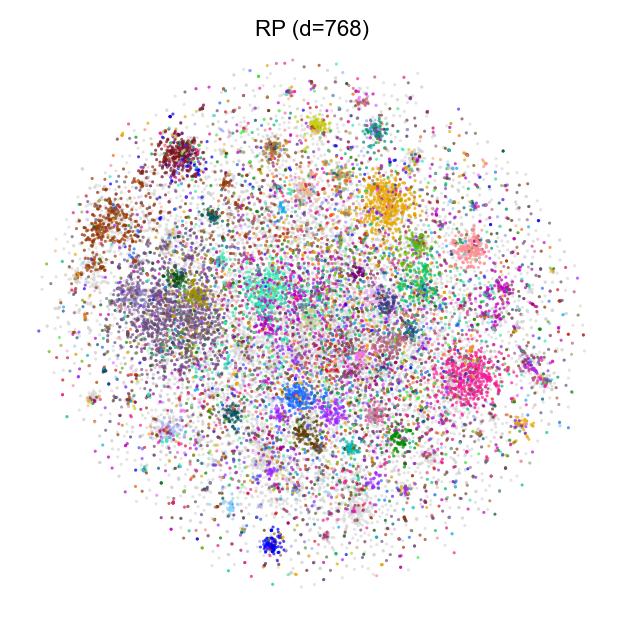

In [65]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

plot_tsne_colors(tsne_random_projection, colors_iclr, ax=ax)
ax.set_title("RP (d=768)")

## Plot

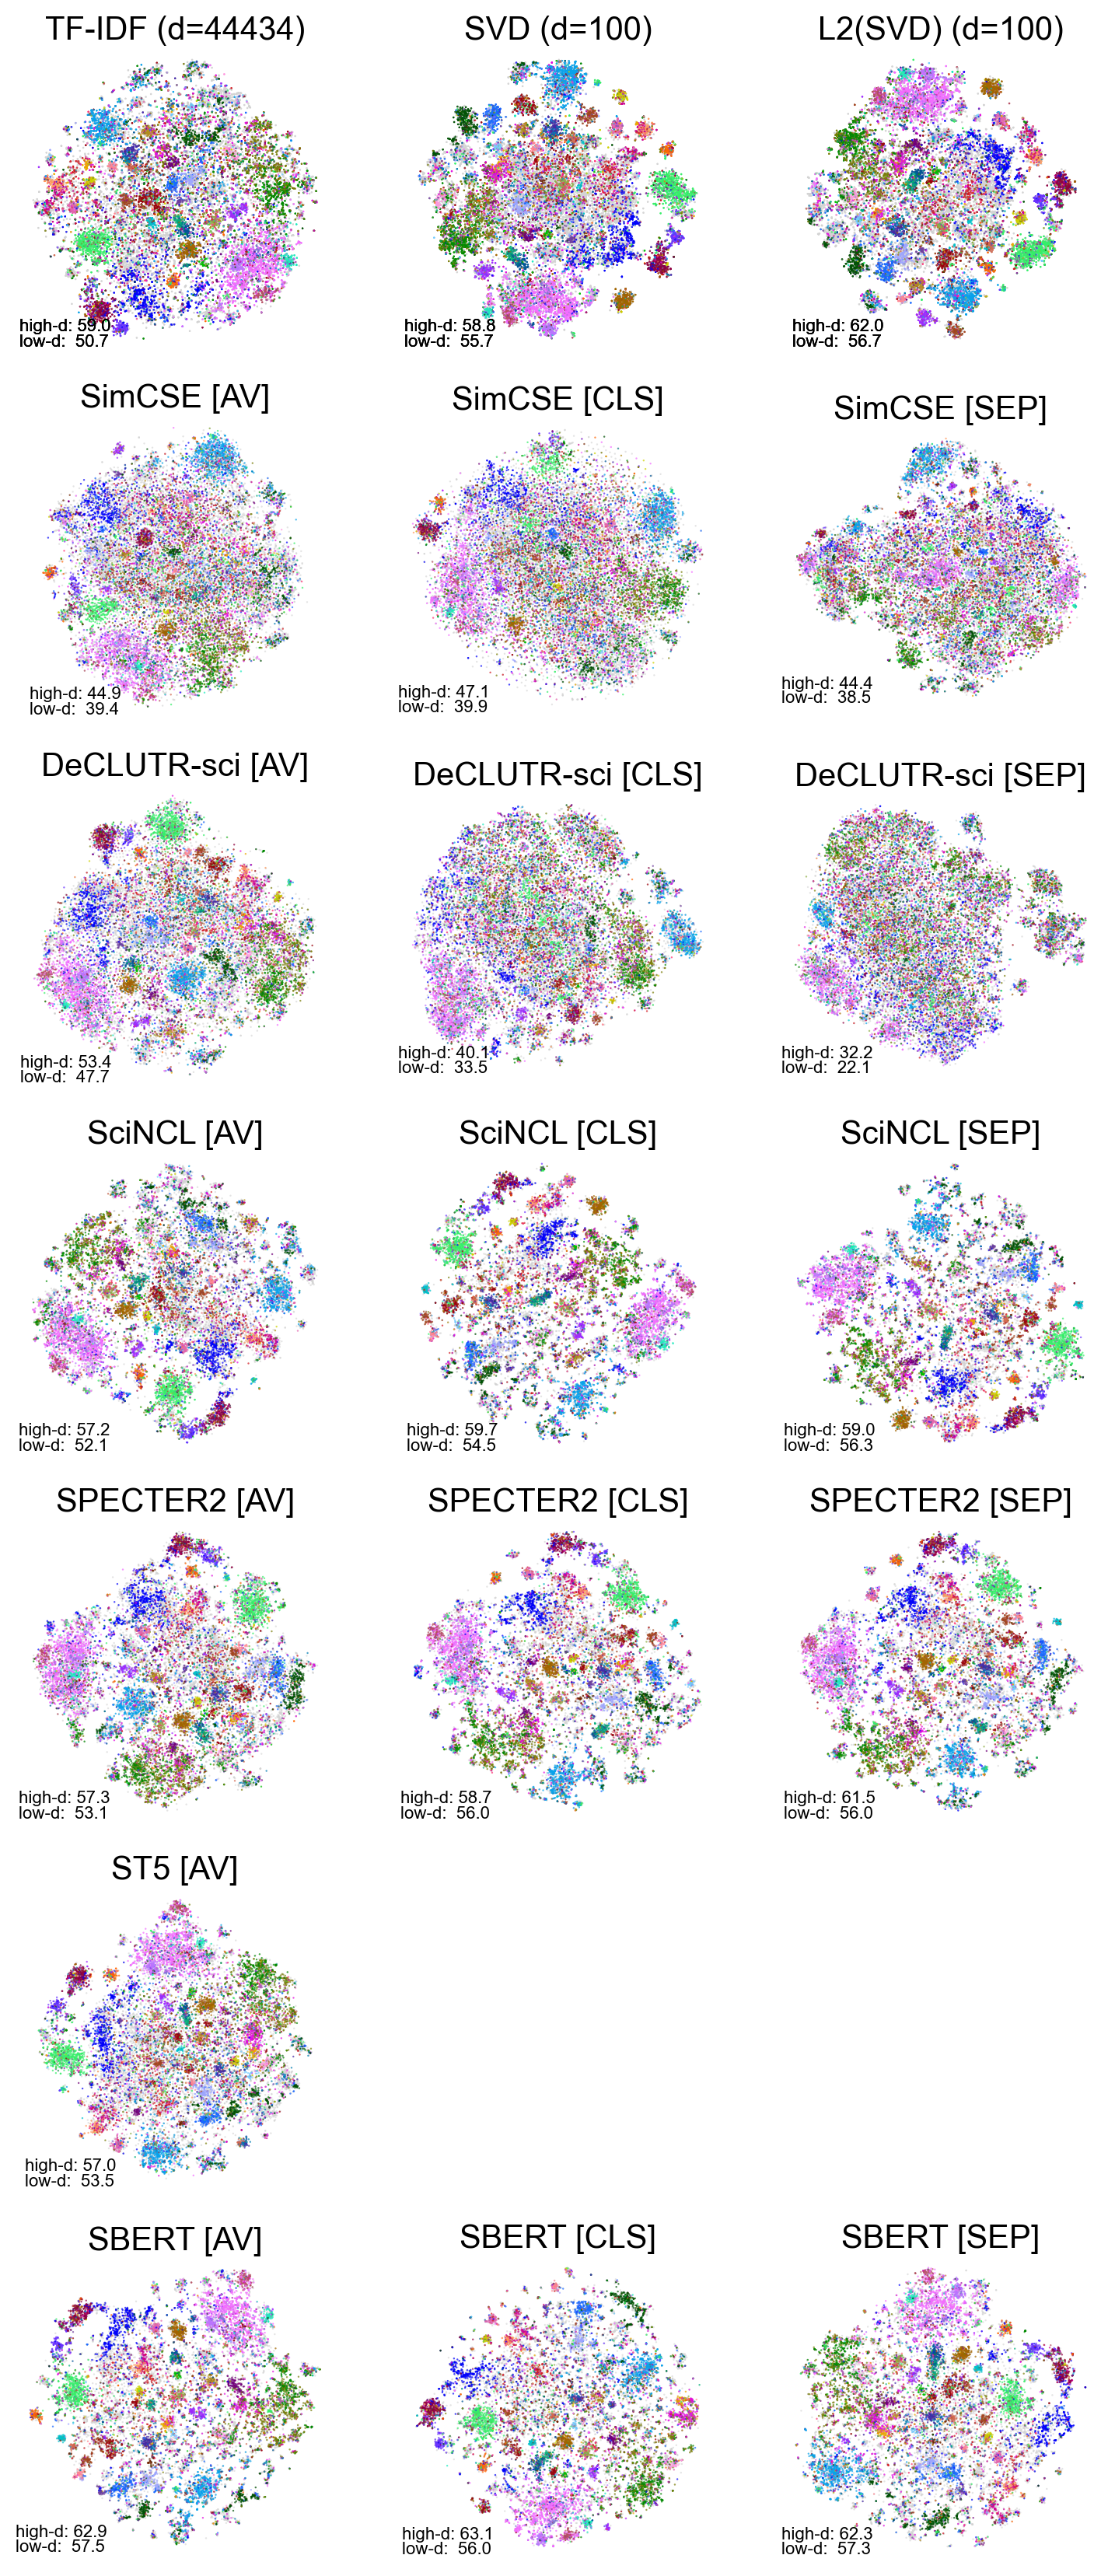

In [87]:
fig, axs = plt.subplots(
    len(model_names) + 1, 3, figsize=(9, 3 * (len(model_names) + 1)), dpi=200
)
rep = ["av", "cls", "sep"]
acc_fontsize = 8
for i in range(len(model_names) + 1):
    for j in range(3):
        if i == 0:
            # load
            ## tsnes
            tsne_tfidf = np.load(variables_path / "tsne_tfidf.npy")
            tsne_svd = np.load(variables_path / "tsne_svd.npy")
            tsne_L2_svd = np.load(variables_path / "tsne_L2_svd.npy")

            ## accuracies
            knn_accuracy_tfidf = np.load(
                variables_path / "knn_accuracy_tfidf.npy"
            )
            knn_accuracy_svd = np.load(variables_path / "knn_accuracy_svd.npy")
            knn_accuracy_L2_svd = np.load(
                variables_path / "knn_accuracy_L2_svd.npy"
            )

            knn_accuracy_tsne_tfidf = np.load(
                variables_path / "knn_accuracy_tsne_tfidf.npy"
            )
            knn_accuracy_tsne_svd = np.load(
                variables_path / "knn_accuracy_tsne_svd.npy"
            )
            knn_accuracy_tsne_L2_svd = np.load(
                variables_path / "knn_accuracy_tsne_L2_svd.npy"
            )

            plot_tsne_colors(
                tsne_tfidf, colors_iclr, ax=axs[i, 0], plot_type="subplot_3"
            )
            axs[i, 0].set_title(f"TF-IDF (d=44434)", fontsize=15)

            axs[i, 0].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 0].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_tfidf*100:.1f}",
                transform=axs[i, 0].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )

            plot_tsne_colors(
                tsne_svd,
                colors_iclr,
                ax=axs[i, 1],
                plot_type="subplot_3",
            )
            axs[i, 1].set_title("SVD (d=100)", fontsize=15)
            axs[i, 1].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 1].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_svd*100:.1f}",
                transform=axs[i, 1].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )

            plot_tsne_colors(
                tsne_L2_svd,
                colors_iclr,
                ax=axs[i, 2],
                plot_type="subplot_3",
            )
            axs[i, 2].set_title("L2(SVD) (d=100)", fontsize=15)
            axs[i, 2].text(
                0,
                0.06,
                f"high-d: {knn_accuracy_L2_svd*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
            axs[i, 2].text(
                0,
                0.01,
                f"low-d:  {knn_accuracy_tsne_L2_svd*100:.1f}",
                transform=axs[i, 2].transAxes,
                va="bottom",
                ha="left",
                size=acc_fontsize,
            )
        else:
            # break
            # load
            ## tsnes
            if (model_names[i - 1] == "ST5") & ((j == 1) | (j == 2)):
                axs[i, j].axis("off")
                continue

            else:
                saving_path = Path("embeddings_" + model_names[i - 1].lower())
                tsne_name = "tsne_" + rep[j] + ".npy"
                tsne = np.load(variables_path / saving_path / tsne_name)

                ## accuracies
                saving_name = Path(
                    "knn_accuracy_" + model_names[i - 1].lower() + ".npy"
                )
                knn_acc_highd = np.load(variables_path / saving_name)

                saving_name = Path(
                    "knn_accuracy_tsne_" + model_names[i - 1].lower() + ".npy"
                )
                knn_acc_lowd = np.load(variables_path / saving_name)

                # plot
                plot_tsne_colors(
                    tsne, colors_iclr, ax=axs[i, j], plot_type="subplot_3"
                )
                title = model_names[i - 1] + " [" + rep[j].upper() + "]"
                axs[i, j].set_title(title, fontsize=15)

                if model_names[i - 1] == "ST5":
                    axs[i, j].text(
                        0,
                        0.06,
                        f"high-d: {knn_acc_highd*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                    axs[i, j].text(
                        0,
                        0.01,
                        f"low-d:  {knn_acc_lowd[0]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                else:
                    axs[i, j].text(
                        0,
                        0.06,
                        f"high-d: {knn_acc_highd[j]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )
                    axs[i, j].text(
                        0,
                        0.01,
                        f"low-d:  {knn_acc_lowd[j]*100:.1f}",
                        transform=axs[i, j].transAxes,
                        va="bottom",
                        ha="left",
                        size=acc_fontsize,
                    )

fig.savefig(figures_path / "tsne_embeddings_iclr_with_knn_accs_v1.png")